In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pickle
import os
import datetime
from tensorflow import keras
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [3]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

# Clear any logs from previous runs
!rm -rf ./logs/

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 4GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)]
    )
  except RuntimeError as e:
    print(e)

devices = tf.config.list_physical_devices()
print("Available devices:\n", devices)
gpus = tf.config.list_physical_devices("GPU")
tf.config.set_visible_devices(gpus[0], "GPU")
logical_gpus = tf.config.experimental.list_logical_devices("GPU")
print("Using GPU:", logical_gpus[0].name)

Available devices:
 [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Using GPU: /device:GPU:0


In [5]:
data = pd.read_csv('./data/train_data_subsampled_autocorr.csv')

y = data['R']
X = data.drop(['R'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [6]:
print(X_test.shape)
print(X_train.shape)

(257, 5)
(1025, 5)


In [7]:
# model = keras.Sequential([
#     keras.layers.Dense(17, activation='tanh', input_shape=(17,), kernel_initializer='glorot_normal'),
#     keras.layers.Dense(7, activation='tanh', kernel_initializer='glorot_normal'),
#     keras.layers.Dropout(rate=0.2),
#     keras.layers.Dense(7, activation='tanh', kernel_initializer='glorot_normal'),
#     keras.layers.Dense(1)
# ])
model = keras.Sequential([
    keras.layers.Dense(5, activation='tanh', input_shape=(5,), kernel_initializer='glorot_normal'),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(3, activation='tanh', kernel_initializer='glorot_normal'),
    keras.layers.Dense(1)
])

# Create the optimizer
optimizer = keras.optimizers.Adam(learning_rate = 0.005, beta_1=0.9, beta_2=0.999)

# Compile the model
model.compile(optimizer=optimizer, loss='mse')

# Train the model
epochs = 100  # Number of training iterations
batch_size = 8  # Number of samples per gradient update

# Create a learning rate scheduler
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-3)

# Create an early stopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode="min", restore_best_weights=True)

# Add the scheduler to the callbacks list
callbacks = [lr_scheduler, early_stopping_callback]

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=callbacks, validation_split=0.2)

Epoch 1/100
103/103 [==============================] - 1s 2ms/step - loss: 8.5945e-04 - val_loss: 3.5321e-04 - lr: 0.0050
Epoch 2/100
103/103 [==============================] - 0s 1ms/step - loss: 4.1447e-04 - val_loss: 3.8974e-04 - lr: 0.0050
Epoch 3/100
103/103 [==============================] - 0s 1ms/step - loss: 3.7883e-04 - val_loss: 3.0156e-04 - lr: 0.0050
Epoch 4/100
103/103 [==============================] - 0s 1ms/step - loss: 3.4981e-04 - val_loss: 3.2066e-04 - lr: 0.0050
Epoch 5/100
103/103 [==============================] - 0s 1ms/step - loss: 3.1552e-04 - val_loss: 2.8356e-04 - lr: 0.0025
Epoch 6/100
103/103 [==============================] - 0s 1ms/step - loss: 3.1852e-04 - val_loss: 2.7526e-04 - lr: 0.0025
Epoch 7/100
103/103 [==============================] - 0s 1ms/step - loss: 3.0935e-04 - val_loss: 3.4415e-04 - lr: 0.0025
Epoch 8/100
103/103 [==============================] - 0s 1ms/step - loss: 3.0181e-04 - val_loss: 3.0387e-04 - lr: 0.0012
Epoch 9/100
103/103 [===

In [28]:
# Evaluate the model
loss = model.evaluate(X_test, y_test)
print("Test loss:", loss)

# Make predictions using the trained model
predictions = model.predict(X_test)

9/9 [==============================] - 0s 853us/step - loss: 1.6739e-04


Test loss: 0.00016739015700295568
9/9 [==============================] - 0s 479us/step


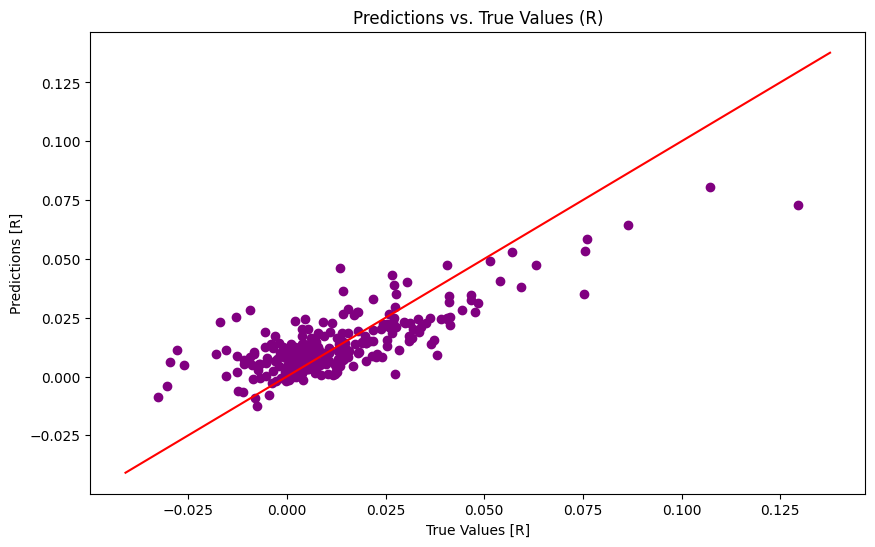

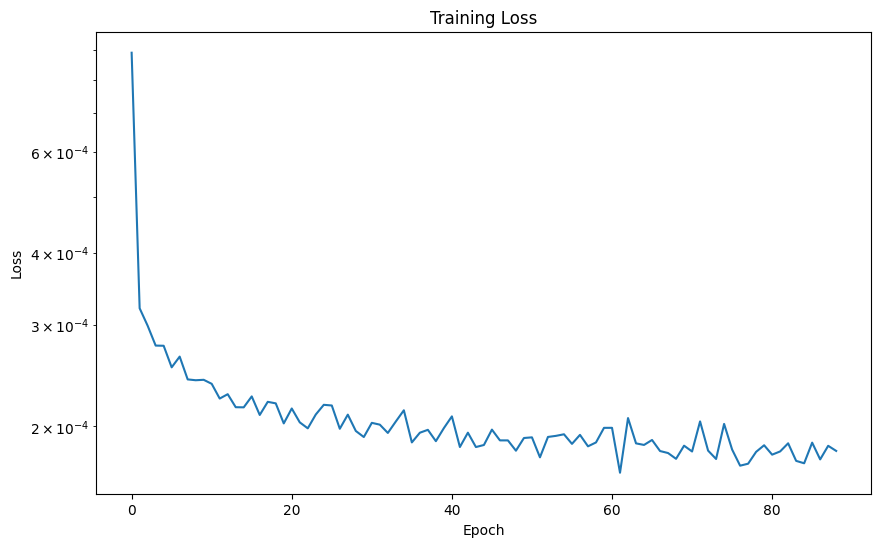

In [29]:
# Plot the predictions against the actual values
plt.figure(figsize=(10, 6))
plt.scatter(pd.DataFrame(y_test).iloc[:,0], predictions, color='purple')
plt.xlabel('True Values [R]')
plt.ylabel('Predictions [R]')
plt.title('Predictions vs. True Values (R)')
# Make a 45 degree line in the same scale and range
x = np.linspace(*plt.gca().get_xlim())
plt.plot(x, x,'-', color='red')

# Plot the loss vs. epochs
plt.figure(figsize=(10, 6))
plt.semilogy(history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

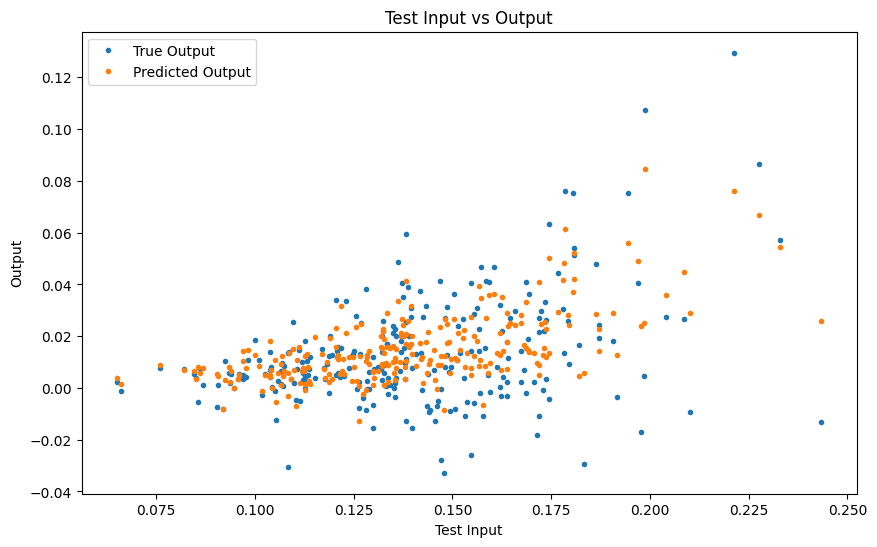

In [22]:
plt.figure(figsize=(10, 6))
#Plot the true output and the predicted output
plt.plot(pd.DataFrame(X_test).iloc[:,0], pd.DataFrame(y_test).iloc[:,0],'.', label='True Output')
plt.plot(pd.DataFrame(X_test).iloc[:,0], predictions,'.', label='Predicted Output')
plt.xlabel('Test Input')
plt.ylabel('Output')
plt.title('Test Input vs Output')
plt.legend()
plt.show()

In [15]:
# Modify the column 1 for X_test to produce its mean
X_test.iloc[:, 1] = X_test.iloc[:, 1].mean()
# Modify the columns 2 for X_test to produce its mean
X_test.iloc[:, 2] = X_test.iloc[:, 2].mean()
# Modify the columns 3 for X_test to produce its mean
X_test.iloc[:, 3] = X_test.iloc[:, 3].mean()
# Modify the columns 4 for X_test to produce its mean
X_test.iloc[:, 4] = X_test.iloc[:, 4].mean()
# Modify the columns 5 for X_test to produce its mean
X_test.iloc[:, 5] = X_test.iloc[:, 5].mean()
# Modify the columns 6 for X_test to produce its mean
X_test.iloc[:, 6] = X_test.iloc[:, 6].mean()
# Modify the columns 7 for X_test to produce its mean
X_test.iloc[:, 7] = X_test.iloc[:, 7].mean()
# Modify the columns 8 for X_test to produce its mean
X_test.iloc[:, 8] = X_test.iloc[:, 8].mean()

# Modify the columns 12 for X_test to produce its mean
X_test.iloc[:, 12] = X_test.iloc[:, 12].mean()
# Modify the columns 13 for X_test to produce its mean
X_test.iloc[:, 13] = X_test.iloc[:, 13].mean()
# Modify the columns 14 for X_test to produce its mean
X_test.iloc[:, 14] = X_test.iloc[:, 14].mean()
# Modify the columns 15 for X_test to produce its mean
X_test.iloc[:, 15] = X_test.iloc[:, 15].mean()
# Modify the columns 16 for X_test to produce its mean
X_test.iloc[:, 16] = X_test.iloc[:, 16].mean()

In [16]:
X_test.iloc[:, 0] = np.linspace(0.06,0.215,198001)
X_test.iloc[:, 9] = np.linspace(0.06,0.215,198001)
X_test.iloc[:, 10] = np.linspace(0.06,0.215,198001)
X_test.iloc[:, 11] = np.linspace(0.06,0.215,198001)

In [17]:
#Display X_test
X_test

,U,std,std2,var,var2,skew,skew2,kurt,kurt2,mov_avg,mov_avg2,mov_avg3,exp_mov_avg,exp_mov_avg2,detrend1,detrend2,detrend3
235487,0.060000,0.001269,0.007428,0.000004,0.000082,0.027313,0.119784,-0.825802,-0.64297,0.060000,0.060000,0.060000,0.132657,0.132635,0.000003,0.000029,-0.000068
137916,0.060001,0.001269,0.007428,0.000004,0.000082,0.027313,0.119784,-0.825802,-0.64297,0.060001,0.060001,0.060001,0.132657,0.132635,0.000003,0.000029,-0.000068
863930,0.060002,0.001269,0.007428,0.000004,0.000082,0.027313,0.119784,-0.825802,-0.64297,0.060002,0.060002,0.060002,0.132657,0.132635,0.000003,0.000029,-0.000068
816286,0.060002,0.001269,0.007428,0.000004,0.000082,0.027313,0.119784,-0.825802,-0.64297,0.060002,0.060002,0.060002,0.132657,0.132635,0.000003,0.000029,-0.000068
936151,0.060003,0.001269,0.007428,0.000004,0.000082,0.027313,0.119784,-0.825802,-0.64297,0.060003,0.060003,0.060003,0.132657,0.132635,0.000003,0.000029,-0.000068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
757719,0.214997,0.001269,0.007428,0.000004,0.000082,0.027313,0.119784,-0.825802,-0.64297,0.214997,0.214997,0.214997,0.132657,0.132635,0.000003,0.000029,-0.000068
174946,0.214998,0.001269,0.007428,0.000004,0.000082,0.027313,0.119784,-0.825802,-0.64297,0.214998,0.214998,0.214998,0.132657,0.132635,0.000003,0.000029,-0.000068
914465,0.214998,0.001269,0.007428,0.000004,0.000082,0.027313,0.119784,-0.825802,-0.64297,0.214998,0.214998,0.214998,0.132657,0.132635,0.000003,0.000029,-0.000068
582241,0.214999,0.001269,0.007428,0.000004,0.000082,0.027313,0.119784,-0.825802,-0.64297,0.214999,0.214999,0.214999,0.132657,0.132635,0.000003,0.000029,-0.000068


In [18]:
# Make predictions using the trained model
predictions1 = model.predict(X_test)

6188/6188 [==============================] - 3s 437us/step


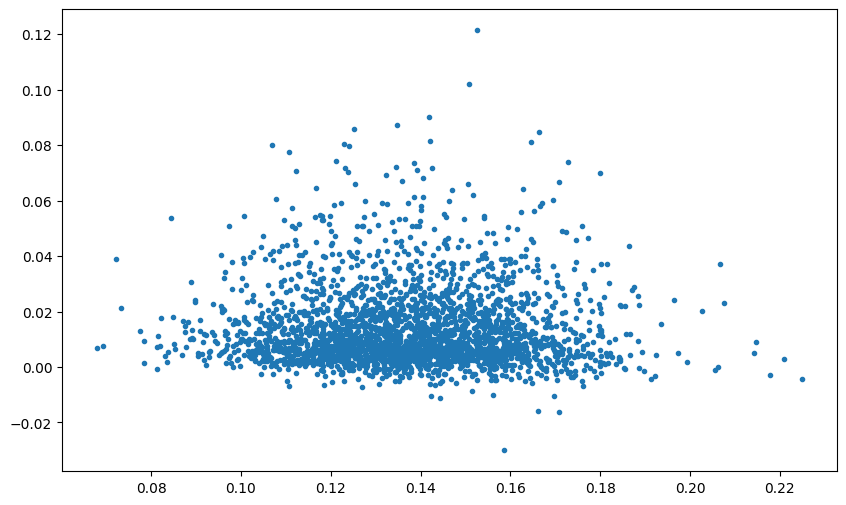

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(X_test.iloc[:, 11], predictions1, '.', label='Predictions')

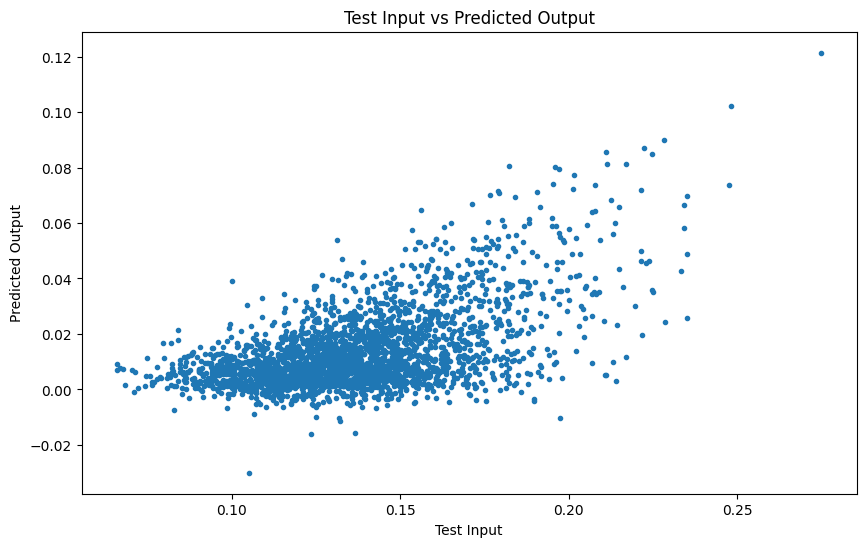

In [19]:
plt.figure(figsize=(10, 6))
#plt.plot(test_input[sorted_indices], predictions[sorted_indices])
plt.plot(pd.DataFrame(X_test).iloc[:,0], predictions, '.')
plt.xlabel('Test Input')
plt.ylabel('Predicted Output')
plt.title('Test Input vs Predicted Output')
plt.show()

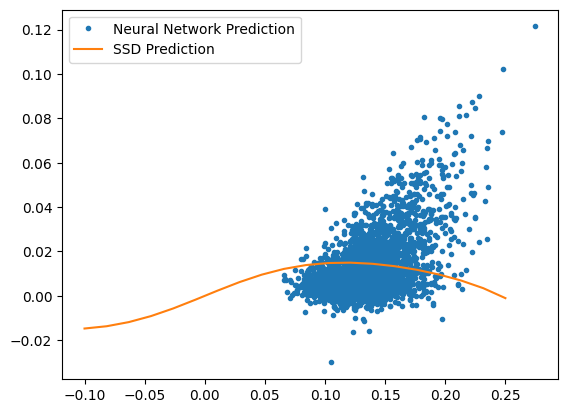

In [26]:
with open("./variables.pickle", "rb") as f:
    R_space, U_space = pickle.load(f)
    
#plt.plot(test_input[sorted_indices], predictions[sorted_indices], label='Neural Network Prediction')
plt.plot(pd.DataFrame(X_test).iloc[:,0], predictions,'.', label='Neural Network Prediction')
plt.plot(U_space, R_space, label='SSD Prediction')
#plt.ylim(0, 0.02)
plt.legend()
plt.show()

# SINE FUNCTION

In [163]:
data = pd.read_csv('./sinx_train_features.csv')
y = data['y']
X = data.drop(['y'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=True, random_state=42)

In [164]:
X_test.shape

(19992, 19)

In [171]:
model = keras.Sequential([
    keras.layers.Dense(19, activation='tanh', input_shape=(19,), kernel_initializer='glorot_normal'),
    keras.layers.Dense(8, activation='tanh', kernel_initializer='glorot_normal'),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(8, activation='tanh', kernel_initializer='glorot_normal'),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(1)
])

# Create the optimizer
optimizer = keras.optimizers.Adam(learning_rate = 0.01)

# Compile the model
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Train the model
epochs = 30  # Number of training iterations
batch_size = 64 # Number of samples per gradient update

# Create a learning rate scheduler
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-8)

# Add the scheduler to the callbacks list
callbacks = [lr_scheduler]

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=callbacks, validation_split=0.1)

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print("Test loss:", loss)

# Make predictions using the trained model
predictions = model.predict(X_test)

Epoch 1/30
422/422 [==============================] - 2s 2ms/step - loss: 0.0213 - mae: 0.1080 - val_loss: 0.0105 - val_mae: 0.0906 - lr: 0.0100
Epoch 2/30
422/422 [==============================] - 1s 2ms/step - loss: 0.0113 - mae: 0.0932 - val_loss: 0.0104 - val_mae: 0.0904 - lr: 0.0100
Epoch 3/30
422/422 [==============================] - 1s 2ms/step - loss: 0.0111 - mae: 0.0924 - val_loss: 0.0105 - val_mae: 0.0909 - lr: 0.0100
Epoch 4/30
422/422 [==============================] - 1s 2ms/step - loss: 0.0108 - mae: 0.0918 - val_loss: 0.0104 - val_mae: 0.0904 - lr: 0.0100
Epoch 5/30
422/422 [==============================] - 1s 2ms/step - loss: 0.0107 - mae: 0.0917 - val_loss: 0.0104 - val_mae: 0.0905 - lr: 0.0100
Epoch 6/30
422/422 [==============================] - 1s 2ms/step - loss: 0.0107 - mae: 0.0917 - val_loss: 0.0104 - val_mae: 0.0904 - lr: 0.0100
Epoch 7/30
422/422 [==============================] - 1s 2ms/step - loss: 0.0107 - mae: 0.0916 - val_loss: 0.0104 - val_mae: 0.090

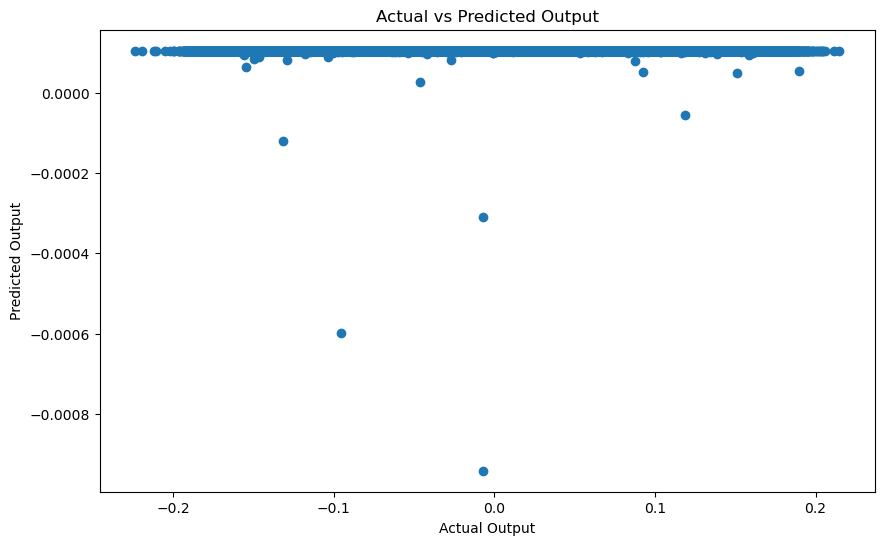

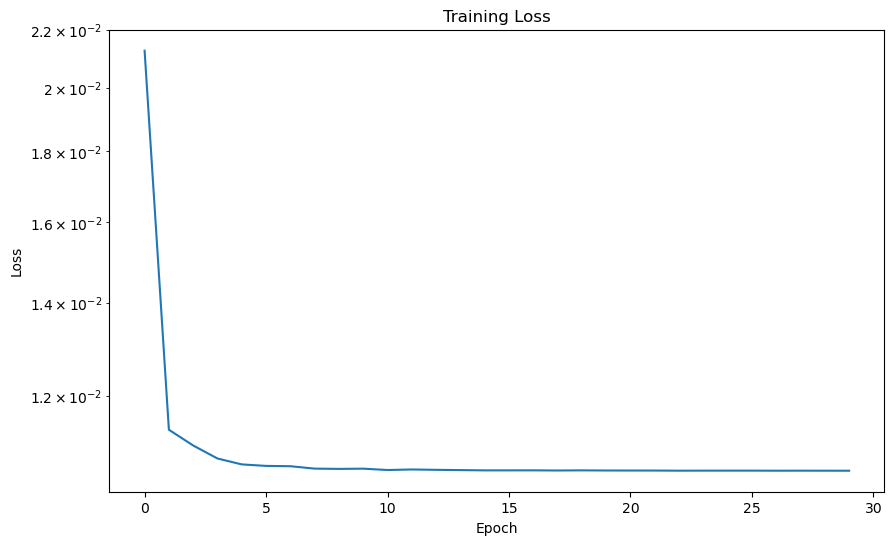

In [172]:
# Plotting the results

plt.figure(figsize=(10, 6))
plt.scatter(pd.DataFrame(y_test).iloc[:,0], predictions)
plt.xlabel('Actual Output')
plt.ylabel('Predicted Output')
plt.title('Actual vs Predicted Output')
plt.show()

plt.figure(figsize=(10, 6))
plt.semilogy(history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

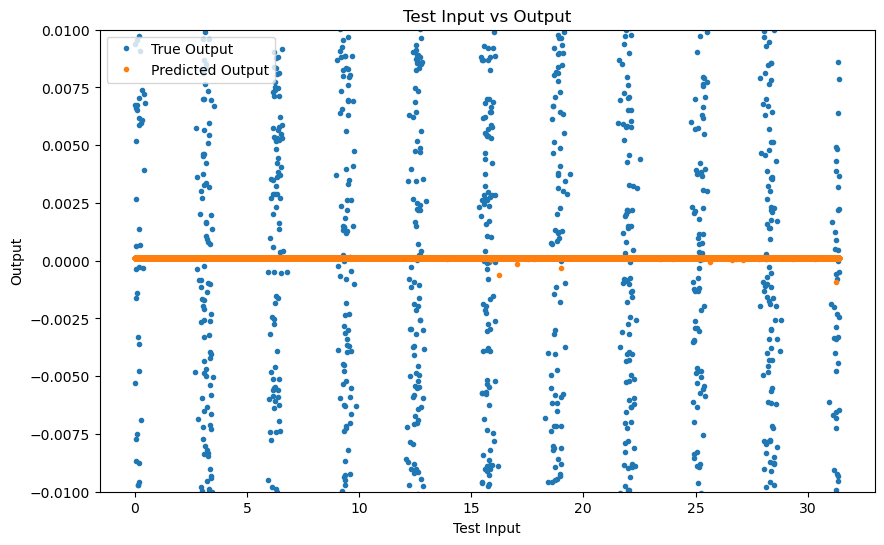

In [173]:
plt.figure(figsize=(10, 6))
#Plot the true output and the predicted output
plt.plot(pd.DataFrame(X_test).iloc[:,0], pd.DataFrame(y_test).iloc[:,0],'.', label='True Output')
plt.plot(pd.DataFrame(X_test).iloc[:,0], predictions,'.', label='Predicted Output')
plt.xlabel('Test Input')
plt.ylabel('Output')
plt.title('Test Input vs Output')
plt.ylim(-0.01,0.01)
plt.legend()
plt.show()